In [1]:
#!/usr/bin/env python3
# coding=utf-8
import pandas as pd
import numpy as np
import sqlite3
import time
from datetime import datetime, timedelta
import math
import sys
import logging
import os
# from scipy import stats as st
from scipy import stats 
from itertools import product as product
from matplotlib import pyplot as plt
# from sklearn.linear_model import LogisticRegression
import warnings
import statsmodels.api as sm
from math import sqrt
from tqdm import tqdm
# import pymssql

warnings.filterwarnings('ignore')
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# conn = pymssql.connect("127.0.0.1", "sa", "quant@123", "test_block")
# cursor = conn.cursor()

g_worthDir = '../pkl'  # 
g_parentDir = '../../..'  # 
g_dbfile = f"{g_parentDir}/pkl/hq.db" # 
g_name = g_access = 'amihud'

g_locTimeadj = 28800 # 28800 0
g_version = '1.0.1'

print(f"{sys.version} , {sys.executable} , pandas: {pd.__version__}")
print(f"{time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()+g_locTimeadj))} *****import**v{g_version}*** ")

3.10.4 (main, Nov 29 2022, 20:00:25) [GCC 9.4.0] , /home/codespace/.python/current/bin/python3 , pandas: 1.5.2
2022-12-29 10:32:18 *****import**v1.0.1*** 


In [2]:
###日志 logger##20220825A######
def make_logger(name, log_level=logging.INFO, log_file="log.txt", file_mode="a"): #w写 a追加
    formatter = logging.Formatter('%(asctime)s:%(levelname)s:%(name)s:%(filename)s:%(lineno)d:%(funcName)s:%(process)s: %(message)s')
    
    logger = logging.getLogger(name)
    if not logger.handlers:
        logger.setLevel(level=log_level)
        handler = logging.FileHandler(log_file, mode=file_mode)
        handler.setLevel(level=log_level)
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        handler = logging.StreamHandler(sys.stdout)
        handler.setLevel(level=log_level)
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    return logger

logger = make_logger(g_name, log_level=logging.DEBUG, log_file= f"{g_parentDir}/logs/{g_name if ('g_name' in dir() ) else 'test' }_{ time.strftime('%Y%m%d') }.log" )

print( f'{time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()+g_locTimeadj))} *****logging***** ')

2022-12-29 10:32:21 *****logging***** 


In [ ]:
if_print = 0
wid_ = np.arange(12)*4*12 + 144      # 12 [144 192 240 288 336 384 432 480 528 576 624 672]
thd = np.arange(31)*0.01+0.6       # 31 [0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 ]
wid_back = np.arange(10)*5+10      # 10 [10 15 20 25 30 35 40 45 50 55]
thd_std = np.arange(6)*0.5 + 0.5   # 6  [0.5 1.  1.5 2.  2.5 3. ]
df_para= pd.DataFrame(list(product(wid_, thd,wid_back,thd_std)))  # 22320 = 12*31*10*6 
df_para.columns = ['wid_','thd','wid_back','thd_std']

df_para['re'] = np.nan
df_para['std'] = np.nan   #  22319   672  0.9 55 3.0 NaN  NaN

# print(f"wid_.head(2) :\n{wid_.head(2)}")
# print(f"wid_.tail(2) :\n{wid_.tail(2)}")

print(f"wid_ {len(wid_)} :\n{wid_}")
print(f"wid_[:5] :\n{wid_[:5]}")
print(f"wid_[-5:] :\n{wid_[-5:]}")

print(f"thd {len(thd)} :\n{thd}")
print(f"thd[:5] :\n{thd[:5]}")
print(f"thd[-5:] :\n{thd[-5:]}")

print(f"wid_back {len(wid_back)} :\n{wid_back}")
print(f"wid_back[:5] :\n{wid_back[:5]}")
print(f"wid_back[-5:] :\n{wid_back[-5:]}")

print(f"thd_std {len(thd_std)} :\n{thd_std}")
print(f"thd_std[:5] :\n{thd_std[:5]}")
print(f"thd_std[-5:] :\n{thd_std[-5:]}")

print(f"df_para.head(2) :\n{df_para.head(2)}")
print(f"df_para.tail(2) :\n{df_para.tail(2)}")

# 1222
print(f"df_para.iloc[1222] :\n{df_para.iloc[1222]}") # 1222  144.0  0.8  25.0  2.5 NaN  NaN  


In [3]:
# ukdf.to_pickle(f"{g_worthDir}/uk5mdf.pkl" )
# ##df_uk = pd.read_pickle(f"{g_worthDir}/uk5mdf.pkl" )

# df_uk = pd.read_pickle(f"{g_parentDir}/pkl/uk5mdf.pkl" )
df_uk = pd.read_pickle(f"/workspaces/jupyter/tmp/uk5m_2021df.pkl" )
# df_uk.tail(2)
# print(f"{df_uk.iloc[-2:,:]}")
# display(df_uk.tail(2) )
print(f"df_uk.tail(2) :\n{df_uk.tail(2)}")

df_input = pd.DataFrame()
# df_input['date'] = df_uk['closeTime'].apply(lambda x: time.strftime("%Y%m%d",time.localtime(float(x)/1000) ) )
df_input['date'] = df_uk['tradeDate']
df_input['timestamp'] = df_uk['closeSec']
df_input['closeTime'] = df_uk['closeTime']
df_input['open'] = df_uk['open']
df_input['high'] = df_uk['high']
df_input['low'] = df_uk['low']
df_input['close'] = df_uk['close']
df_input['vol'] = df_uk['vol']
df_input['amount'] = df_uk['amt']
df_input['amt'] = df_uk['amt']/( df_uk['high']+ df_uk['low'])*2

# df_input.tail(2)
# display(df_input.tail(2) )
print(f"df_input.tail(2) :\n{df_input.tail(2)}")


df_uk.tail(2) :
       tradeDate openTime closeTime    closeSec     open    close     high  \
209227  20221228   113500    113959  1672198799  16824.8  16658.8  16824.8   
209228  20221228   114000    114459  1672199099  16652.5  16828.8  16828.8   

            low         vol           amt       pct  
209227  16647.0  468.325989  7.811034e+06  0.000228  
209228  16646.2  205.018997  3.424889e+06  0.010205  
df_input.tail(2) :
            date   timestamp closeTime     open     high      low    close  \
209227  20221228  1672198799    113959  16824.8  16824.8  16647.0  16658.8   
209228  20221228  1672199099    114459  16652.5  16828.8  16646.2  16828.8   

               vol        amount         amt  
209227  468.325989  7.811034e+06  466.723286  
209228  205.018997  3.424889e+06  204.623700  


In [4]:
def func(idx,df_input,thd):  # thd 0.8
    # thd = 3
    # print(f"{idx = }")
    idx = [int(i) for i in idx] # 144: 0~143
    ds = df_input.iloc[idx]
    thd = thd * 100
    ds['amt'] = ds['amt'] * (ds['high'] + ds['low']) / 2
    amt_sum = np.sum(ds['amt'])
    ds = ds[ds['indicator']>np.percentile(ds['indicator'],thd)]  # 分位数 80% 
    amt_pct = np.sum(ds['amt'])
    # ds['pct'] = np.sum(ds['amt']*(ds['high']+ds['low']))
    return amt_pct / amt_sum / (1-thd/100)


In [17]:
# df_s['value']

ds = df_s.tail(144)
print(f"{ds.tail(1) = }")

print(f"{df_s['value'].iloc[-1] = }")
amt_sum1 = np.sum(ds['amount']) # idx rolling(int(wid_) 144
print(f"{amt_sum1 = }")

ds1 = ds[ds['indicator_0']>np.percentile(ds['indicator_0'],80)]   # thd 80
# print(f"{ds1 = }")
amt_pct1 = np.sum(ds1['amount'])
print(f"{amt_pct1 = }")
print(f"value: {amt_pct1 / amt_sum1 / (1-0.8) = }") # thd/100



ds.tail(1) =           date   timestamp closeTime     open     high      low    close  \
8762  20221123  1669169699    101459  16250.0  16300.0  16250.0  16250.5   

              vol        amount          amt  ...  indicator   indicator_0  \
8762  1059.088013  1.721557e+07  1057.792415  ...          0  2.908816e-08   

      index     value  signal  value_mean  value_std  position       nav     x  
8762   8762  0.912582     NaN      0.8694    0.10761       1.0  0.710753  8762  

[1 rows x 21 columns]
df_s['value'].iloc[-1] = 0.9125822105857402
amt_sum1 = 1231965242.1116
amt_pct1 = 224853912.80220002
value: amt_pct1 / amt_sum1 / (1-0.8) = 0.9125822105857402


In [5]:
# loading_data('btc',wid_,thd,if_print,int(row_para[2]),row_para[3]) # 144.0 0.8 25.0 2.5 NaN  NaN
wid_ = 144.0 
thd = 0.8 
wid_back = 25.0 
thd_std = 2.5 

df_s = df_input.copy()

df_s['pct'] = df_s['close'] / df_s['close'].shift(1) - 1
df_s.fillna(0, inplace=True)
df_s['indicator'] = abs(df_s['pct']) /df_s['amt']
df_s['indicator_0'] = df_s['indicator']
df_s['index'] = df_s.index
df_s['value'] = df_s['index'].rolling(int(wid_)).apply(lambda x: func(x, df_s, thd)) # wid_ 144, thd 0.8

df_s['signal'] = np.nan
df_s['value_mean'] = df_s['value'].rolling(int(wid_*int(wid_back)) ).mean()  # wid_back 25 , 3600
df_s['value_std'] = df_s['value'].rolling(int(wid_*int(wid_back)) ).std()  # wid_back 25
df_s['signal'] = np.where((df_s['value'] > df_s['value_mean']+thd_std*df_s['value_std']), 1, df_s['signal'])   # thd_std 2.5
df_s['signal'] = np.where((df_s['value'] < df_s['value_mean']-thd_std*df_s['value_std']), -1, df_s['signal'])   # thd_std 2.5

print(f"df_s.tail(5) :\n{df_s.tail(5)}")

df_s.to_pickle(f"df_s.pkl" )
#df_s = pd.read_pickle(f"df_s.pkl" )

df_s.tail(5) :
            date   timestamp closeTime     open     high      low    close  \
209224  20221228  1672197899    112459  16650.0  16782.8  16650.0  16695.0   
209225  20221228  1672198199    112959  16755.0  16823.1  16627.2  16655.4   
209226  20221228  1672198499    113459  16654.7  16824.8  16627.2  16655.0   
209227  20221228  1672198799    113959  16824.8  16824.8  16647.0  16658.8   
209228  20221228  1672199099    114459  16652.5  16828.8  16646.2  16828.8   

               vol        amount         amt       pct     indicator  \
209224  366.703003  6.128018e+06  366.587207  0.002703  7.372605e-06   
209225  512.905029  8.575377e+06  512.723467 -0.002372  4.626212e-06   
209226  269.179993  4.492270e+06  268.580048 -0.000024  8.941928e-08   
209227  468.325989  7.811034e+06  466.723286  0.000228  4.888544e-07   
209228  205.018997  3.424889e+06  204.623700  0.010205  4.987114e-05   

         indicator_0   index     value  signal  value_mean  value_std  
209224  7.3

In [13]:
print(f"{ df_s.shape }")
print(f"{ df_s.tail(2) }")
# df_s2 = df_s[df_s['signal']>-2]
df_s2 = df_s[~df_s['signal'].isnull()]

print(f"{ df_s2.shape }")
print(f"{ df_s2.tail(2) }")


(209229, 18)
            date   timestamp closeTime     open     high      low    close  \
209227  20221228  1672198799    113959  16824.8  16824.8  16647.0  16658.8   
209228  20221228  1672199099    114459  16652.5  16828.8  16646.2  16828.8   

               vol        amount         amt       pct     indicator  \
209227  468.325989  7.811034e+06  466.723286  0.000228  4.888544e-07   
209228  205.018997  3.424889e+06  204.623700  0.010205  4.987114e-05   

         indicator_0   index     value  signal  value_mean  value_std  
209227  4.888544e-07  209227  0.809978     NaN    0.840188   0.126537  
209228  4.987114e-05  209228  0.799305     NaN    0.840127   0.126504  
(8492, 18)
            date   timestamp closeTime     open     high      low    close  \
206026  20221217  1671238499    085459  16706.8  16810.0  16696.7  16726.0   
206027  20221217  1671238799    085959  16716.2  16718.0  16700.0  16705.8   

               vol        amount         amt       pct  indicator  \
2060

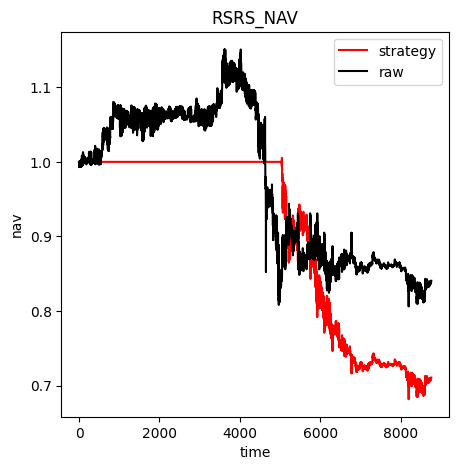

In [6]:
cost_ = -0.0016 
if_print = 1

df_s['position'] = df_s['signal']
df_s['position'].iloc[0] = 0
df_s['position'].fillna(method='pad', inplace=True)
df_s['indicator'] = np.where(df_s['position'] != df_s['position'].shift(1), 1, 0)
df_s['position'] = np.where(df_s['position'] != df_s['position'].shift(1), df_s['position'].shift(1),df_s['position'])
# 是否可以做空
# df_s['position'] = np.where(df_s['position']==-1,0,df_s['position'])

df_s['pct'] = (df_s['close'] / df_s['close'].shift(1) - 1) * df_s['position'] + df_s['indicator'] * cost_
std_ = np.std(df_s['pct']) * sqrt(365 * 24*12)
df_s['nav'] = (df_s['pct'] + 1).cumprod()
df_s['pct'] = df_s['close'] / df_s['close'].iloc[0]
df_s['x'] = df_s.index
# plot_average_cumulative_return(df_s, 'zscore', after=10, title='标准分未来10日上涨概率')
# plot_average_cumulative_return(df_s, 'zscore', after=20, title='修正标准分未来10日期望收益', probability=False)

# plt.plot
# df_s.to_csv(r"C:\Users\wangjian\Desktop\\data_result.csv",index=False)
df_s.to_csv(r"data_result.csv",index=False)

df_s.to_pickle(f"df_s2.pkl" )
##df_s = pd.read_pickle(f"df_s2.pkl" )

# 画图
if if_print == 1:
    fig = plt.figure(figsize=(5, 5))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(df_s['nav'], 'r-', label='strategy')
    ax1.plot(df_s['pct'], 'k-', label='raw')
    plt.xlabel('time')
    plt.ylabel('nav')
    plt.title('RSRS_NAV')
    plt.legend()
    plt.show()
# cal re,std_
re_ = df_s['nav'].iloc[-1] ** (365.0 * 24 * 12 / len(df_s.index)) - 1
# print(df_s['nav'].iloc[-1],len(df_s.index))

# df_s.dropna(how='any',inplace=True)
# stat_depict(df_s, 'beta')
# stat_depict_plot(df_s, 'beta', 'distribution')
# cal regression zscore


In [4]:
# df_s.to_pickle(f"df_s2.pkl" )
df_s2r = pd.read_pickle(f"df_s2.pkl" )
print(f"{df_s2r = }")

df_s2r =           date   timestamp closeTime          open          high  \
0     20221024  1666541099    000459  19335.000000  19335.000000   
1     20221024  1666541399    000959  19334.000000  19339.000000   
2     20221024  1666541699    001459  19205.000000  19339.000000   
3     20221024  1666541999    001959  19301.300000  19339.000000   
4     20221024  1666542299    002459  19249.100000  19339.000000   
...        ...         ...       ...           ...           ...   
8758  20221123  1669168499    095459  16211.599609  16223.599609   
8759  20221123  1669168799    095959  16213.900391  16229.900391   
8760  20221123  1669169099    100459  16224.200195  16246.000000   
8761  20221123  1669169399    100959  16227.200195  16251.599609   
8762  20221123  1669169699    101459  16250.000000  16300.000000   

               low         close          vol        amount          amt  ...  \
0     19200.200000  19335.000000    18.882999  3.636677e+05    18.874573  ...   
1     19201.

In [5]:
def fun_k1(idx, df):
    idx = [int(i) for i in idx]
    # idx=idx-idx[0]
    reg2= np.polyfit(idx,np.array(df['close'][idx]),3)  # slope intercept rvalue pvalue
    k = 3*reg2[0]*idx[-1]**2+2*reg2[1]*idx[-1]+reg2[2]
    return k

def fun_k2(idx, df):
    idx = [int(i) for i in idx]
    # idx=idx-idx[0]
    reg2= np.polyfit(idx,np.array(df['close'][idx]),3)  # slope intercept rvalue pvalue
    k = 6*reg2[0]*idx[-1]+2*reg2[1]
    return k

In [5]:
def func(idx,df_input,thd):  # thd 0.8
    # thd = 3
    idx = [int(i) for i in idx]
    ds = df_input.iloc[idx]
    thd = thd * 100
    ds['amt'] = ds['amt'] * (ds['high'] + ds['low']) / 2
    amt_sum = np.sum(ds['amt'])
    ds = ds[ds['indicator']>np.percentile(ds['indicator'],thd)]
    amt_pct = np.sum(ds['amt'])
    # ds['pct'] = np.sum(ds['amt']*(ds['high']+ds['low']))
    return amt_pct / amt_sum / (1-thd/100)


def cal_pct(cate_id,wid_,thd):
    cost_ = -0.0016
    sql_str = "SELECT ymd,hms,[open],high,low,[close],amount/(high+low)*2   from [test_block].[dbo].[adj_data]" \
              "  where category ='" + str(cate_id) + "' and window=5   and ymd >'2020-12-31' order by ymd,hms"
    # print(sql_str)
    cursor.execute(sql_str)
    df_id = pd.DataFrame(cursor.fetchall(), columns=['daytime', 'hms', 'open', 'high', 'low', 'close', 'amt'])
    df_id['pct'] = df_id['close'] / df_id['close'].shift(1) - 1
    df_id.fillna(0, inplace=True)
    df_id['indicator'] = abs(df_id['pct']) / df_id['amt']
    df_id['index'] = df_id.index
    df_id['value'] = df_id['index'].rolling(int(wid_)).apply(lambda x: func(x, df_id, thd))
    df_id.to_csv(r"C:\Users\wangjian\Desktop\strategy\BTC_strategy\Amihud_illiquidity\config\\df_wid_"+str(wid_)+"_thd_"+str(int(thd*100))+".csv")
    return np.nan


In [7]:
def loading_data(cate_id,wid_,thd,if_print,wid_back,thd_std): # wid_ 144.0 , thd 0.8 , wid_back 25.0 , thd_std 2.5 , NaN , NaN

    # loading_data('btc',wid_,thd,if_print,int(row_para[2]),row_para[3]) # 144.0  0.8  25.0  2.5  NaN  NaN
    
    cost_ = -0.0016
    df_id = pd.read_csv(r"C:\Users\wangjian\Desktop\strategy\BTC_strategy\Amihud_illiquidity\config\\df_wid_"+str(wid_)+"_thd_"+str(int(thd*100))+".csv")

    df_s = df_id.copy()
    thd_pct = 1
    df_s['signal'] = np.nan
    df_s['value_mean']=df_s['value'].rolling(wid_*int(wid_back)).mean()
    df_s['value_std'] = df_s['value'].rolling(wid_*int(wid_back)).std()
    df_s['signal'] = np.where((df_s['value'] > df_s['value_mean']+thd_std*df_s['value_std']), 1, df_s['signal'])
    df_s['signal'] = np.where((df_s['value'] < df_s['value_mean']-thd_std*df_s['value_std']), -1, df_s['signal'])


    df_s['position'] = df_s['signal']
    df_s['position'].iloc[0] = 0
    df_s['position'].fillna(method='pad', inplace=True)
    df_s['indicator'] = np.where(df_s['position'] != df_s['position'].shift(1), 1, 0)
    df_s['position'] = np.where(df_s['position'] != df_s['position'].shift(1), df_s['position'].shift(1),
                                df_s['position'])
    # 是否可以做空
    # df_s['position'] = np.where(df_s['position']==-1,0,df_s['position'])

    df_s['pct'] = (df_s['close'] / df_s['close'].shift(1) - 1) * df_s['position'] + df_s['indicator'] * cost_
    std_ = np.std(df_s['pct']) * sqrt(365 * 24*12)
    df_s['nav'] = (df_s['pct'] + 1).cumprod()
    df_s['pct'] = df_s['close'] / df_s['close'].iloc[0]
    df_s['x'] = df_s.index
    # plot_average_cumulative_return(df_s, 'zscore', after=10, title='标准分未来10日上涨概率')
    # plot_average_cumulative_return(df_s, 'zscore', after=20, title='修正标准分未来10日期望收益', probability=False)

    # plt.plot
    df_s.to_csv(r"C:\Users\wangjian\Desktop\\data_result.csv",index=False)

    # 画图
    if if_print == 1:
        fig = plt.figure(figsize=(5, 5))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.plot(df_s['nav'], 'r-', label='strategy')
        ax1.plot(df_s['pct'], 'k-', label='raw')
        plt.xlabel('time')
        plt.ylabel('nav')
        plt.title('RSRS_NAV')
        plt.show()
    # cal re,std_
    re_ = df_s['nav'].iloc[-1] ** (365.0 * 24 * 12 / len(df_s.index)) - 1
    # print(df_s['nav'].iloc[-1],len(df_s.index))

    # df_s.dropna(how='any',inplace=True)
    # stat_depict(df_s, 'beta')
    # stat_depict_plot(df_s, 'beta', 'distribution')
    # cal regression zscore

    return re_, std_


In [ ]:
# if __name__ == '__main__':
# parameter
if_print = 0
wid_=np.arange(12)*4*12 + 144      # 12 [144 192 240 288 336 384 432 480 528 576 624 672]
thd = np.arange(31)*0.01+0.6       # 31 [0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 ]
wid_back = np.arange(10)*5+10      # 10 [10 15 20 25 30 35 40 45 50 55]
thd_std = np.arange(6)*0.5 + 0.5   # 6  [0.5 1.  1.5 2.  2.5 3. ]
df_para= pd.DataFrame(list(product(wid_, thd,wid_back,thd_std)))  # 22320 = 12*31*10*6 
df_para.columns=['wid_','thd','wid_back','thd_std']

df_para['re']=np.nan    #  index   'wid_',  'thd',  'wid_back','thd_std',   're',   'std'
df_para['std']=np.nan   #  22319   672      0.9     55          3.0         NaN     NaN
# print(df_para)
for index_para,row_para in tqdm(df_para.iterrows(),total=df_para.shape[0]):

    if index_para!=1222: # 1222  144.0     0.8    25.0        2.5         NaN     NaN
        if_print = 1     # index  'wid_',  'thd',  'wid_back', 'thd_std',  're',   'std'
        continue
    wid_,thd=int(row_para[0]),row_para[1] # 144.0  0.8 

    df_para['re'].iloc[index_para],df_para['std'].iloc[index_para] = loading_data('btc',wid_,thd,if_print,int(row_para[2]),row_para[3]) # 144.0  0.8  25.0  2.5  NaN  NaN
    # break
    df_para['sr']=df_para['re']/df_para['std']
    # df_para.to_csv(r"C:\Users\wangjian\Desktop\strategy\BTC_strategy\Amihud_illiquidity\results\df_results.csv")
    # break

In [ ]:
print(f"{type(df_input['low'].head(25))}")
print(f"{df_input['low'].head(25)}")

In [ ]:
idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
print(f"{type(df_input['low'][idx])}")
print(f"{df_input['low'][idx]}")

In [4]:
def func(idx, df):
    
    # print(f"idx1 :\n{idx}")   
    
    idx = [int(i) for i in idx]
    # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    # print(f"idx2 :\n{idx}")   
        
    result_ = stats.linregress(df['low'][idx], df['high'][idx]) # # slope intercept rvalue pvalue
    
    # LinregressResult(slope=1.4609737282140889, intercept=0.6260166856203904, rvalue=0.76760585460041, pvalue=0.009535323744696659, stderr=0.43128508714183683, intercept_stderr=0.2307834268202402)

    # slope: float 回归线的斜率。
    # intercept: float 回归线的截距。
    # rvalue: float 皮尔逊相关系数。rvalue 的平方等于决定系数。
    # pvalue: float 对零假设为斜率为零的假设检验的p值，使用带有检验统计量t分布的Wald检验。
    # stderr: float 估计的斜率(梯度)的标准误差，在残差正态性的假设下。
    # intercept_stderr: float 估计的截距的标准误差，在残差正态的假设下。
    
    ret = (result_[0]**2)*(result_[2]**2)   # slope^2 * rvalue^2
    # r_2 = (result_[0]**2)*(result_[2]**2)
    return ret

def get_regression(data,reg_window): # 25
    df_s = data.copy()
    df_s['index'] = range(len(df_s)) # range(0, 4059)
    # cal regression beta
    df_s['beta'] = df_s['index'].rolling(reg_window).apply(lambda x: func(x, df_s))
    del df_s['index']
    # df_s.to_csv("ds_reg_"+str(reg_window)+".csv",index=False)
    return df_s

In [12]:
print(f"df_input.tail(2) :\n{df_input.tail(2)}")
df_s = get_regression(df_input, 25) #  i_reg 25
print(f"df_s.tail(2) :\n{df_s.tail(2)}")

# get_data(df_s, 25, 90, 0.6, 1) # 621 # 25  90  0.6  # 1


df_input.tail(2) :
          timestamp          open          high           low         close
4057  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781
4058  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219
df_s.tail(2) :
          timestamp          open          high           low         close  \
4057  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781   
4058  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219   

          beta  
4057  0.721573  
4058  0.706648  


In [6]:
reg_window = 25 ; stat_wid = 90 ; thd = 0.6 
df_s = df_input.copy()
df_s['index'] = range(len(df_s)) # range(0, 4059)
df_s['beta'] = df_s['index'].rolling(reg_window).apply(lambda x: func(x, df_s))
del df_s['index']
df_s['zscore'] = (df_s['beta']-df_s['beta'].rolling(stat_wid).mean())/df_s['beta'].rolling(stat_wid).std()
df_s['signal'] = np.nan
df_s['signal'] = np.where((df_s['zscore'] > thd), 1, df_s['signal'])
df_s['signal'] = np.where((df_s['zscore'] < -thd), -1, df_s['signal'])

print(f"df_s.tail(2) :\n{df_s.tail(2)}")

df_s.tail(2) :
          timestamp          open          high           low         close  \
4057  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781   
4058  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219   

          beta    zscore  signal  
4057  0.721573  0.162299     NaN  
4058  0.706648  0.139154     NaN  


In [8]:
# print(f"range(len(df_input)) :\n{range(len(df_input) ) }")
df_i = df_input.copy()
df_i['index'] = range(len(df_input))
# print( range(len(df_input) ) )  # range(0, 4059)
df_i['beta'] = df_i['index'].rolling(25).apply(lambda x: func(x, df_i))
# print(f"df_i['beta'] :\n{df_i['beta']}")  
del df_i['index']
df_i.to_pickle(f"df_i.pkl" )


df_i['zscore'] = (df_i['beta']-df_i['beta'].rolling(90).mean())/df_i['beta'].rolling(90).std()

# df_i['signal'] = np.nan
# df_i['signal'] = np.where((df_i['zscore'] > thd), 1, df_i['signal'])
# df_i['signal'] = np.where((df_i['zscore'] < -thd), -1, df_i['signal'])
df_i['signal'] = np.where((df_i['zscore'] > thd), 1, np.where((df_i['zscore'] < -thd), -1, np.nan))

print(f"df_i.tail(2) :\n{df_i.tail(2)}")
print(f"df_i['signal'] :\n{df_i['signal']}")



df_i.tail(2) :
          timestamp          open          high           low         close  \
4057  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781   
4058  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219   

          beta    zscore  signal  
4057  0.721573  0.162299     NaN  
4058  0.706648  0.139154     NaN  


In [8]:
stl = stats.linregress(df_i['low'].tail(25), df_i['high'].tail(25) )
ret = (stl[0]**2)*(stl[2]**2)   # slope^2 * rvalue^2

zsc = (df_i['beta'].tail(1) - df_i['beta'].tail(90).mean() ) /df_i['beta'].tail(90).std()

# df_i['zscore'] = (df_i['beta']-df_i['beta'].rolling(90).mean())/df_i['beta'].rolling(90).std()
# df_i['signal'] = np.nan
# df_i['signal'] = np.where((df_i['zscore'] > thd), 1, df_i['signal'])
# df_i['signal'] = np.where((df_i['zscore'] < -thd), -1, df_i['signal'])

# print(f"df_i.tail(2) :\n{df_i.tail(2)}") # df_input['low'].head(25)
print(f"{ret = }, {zsc = } ")

ret = 0.7066475494394989, zsc = 4058    0.139154
Name: beta, dtype: float64 


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


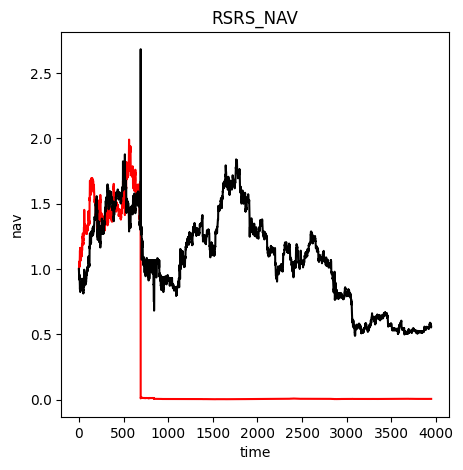

(-0.9434006188736931,
 1.3490418187244397,
 -0.6993116193875348,
 -0.4650613119201296,
 -0.3254579749465731,
 -0.886983869047188)

In [10]:
get_data(df_input,25,90,0.6,1)

In [11]:
df_s = pd.read_pickle(f"df_s.pkl" )
corr_all,corr_right,corr_left = corr_depict(df_s,'zscore')
re_ = df_s['nav'].iloc[-1]**(365.0*6/len(df_s.index)) - 1
std_ = np.std(df_s['pct'])*sqrt(365*6)

print(f"df_s.tail(2) :\n{df_s.tail(2)}")
print(f"re_ :\n{re_}")
print(f"std_ :\n{std_}")
print(f"re_/std_ :\n{re_/std_}")
print(f"corr_all :\n{corr_all}")
print(f"corr_right :\n{corr_right}")
print(f"corr_left :\n{corr_left}")


# re_,std_,re_/std_,corr_all,corr_right,corr_left

df_s.tail(2) :
          timestamp          open          high           low         close  \
3944  1667865599999  20869.800781  21170.000000  20080.000000  20587.800781   
3945  1667879999999  20587.800781  20879.800781  20546.900391  20840.199219   

          beta    zscore            ma  signal  position  indicator       pct  \
3944  0.721573  0.162299  20752.213281     NaN       1.0          0  0.551776   
3945  0.706648  0.139154  20767.883268     NaN       1.0          0  0.558540   

           nav     x  
3944  0.005591  3944  
3945  0.005660  3945  
re_ :
-0.9434006188736931
std_ :
16.505887732580103
re_/std_ :
-0.05715540019162764
corr_all :
-0.4650613119201296
corr_right :
-0.3254579749465731
corr_left :
-0.886983869047188


In [5]:
def get_data(data,reg_window,stat_wid,thd,if_print): # 621 # 25  90  0.6  # 1
    cost_ = -0.0016
    # df_s = data.copy()
    # df_s['index'] = range(len(df_s))
    # # cal regression beta
    # df_s['beta'] = df_s['index'].rolling(reg_window).apply(lambda x: func(x, df_s))
    # del df_s['index']
    # df_s = pd.read_csv("ds_reg_"+str(reg_window)+".csv")  # 25
    
    df_s = pd.read_pickle(f"df_i.pkl" ) # ds_reg_25.csv

    df_s['zscore'] = (df_s['beta']-df_s['beta'].rolling(stat_wid).mean())/df_s['beta'].rolling(stat_wid).std()

    df_s['ma'] = df_s['close'].rolling(60).mean()

    df_s.dropna(how='any',inplace=True)
    df_s.reset_index(drop=True,inplace=True)
    # print(df_s)
    # signal
    df_s['signal'] = np.nan
    # df_s['signal'] = np.where((df_s['zscore']>thd)&(df_s['close']>df_s['ma']),1,df_s['signal'])
    # df_s['signal'] = np.where((df_s['zscore'] < -thd)&(df_s['close']<df_s['ma']), -1, df_s['signal'])
    df_s['signal'] = np.where((df_s['zscore'] > thd), 1, df_s['signal'])
    df_s['signal'] = np.where((df_s['zscore'] < -thd), -1, df_s['signal'])

    df_s['position'] = df_s['signal']
    df_s['position'].iloc[0] = 0
    df_s['position'].fillna(method='pad',inplace=True)
    df_s['indicator'] = np.where(df_s['position']!=df_s['position'].shift(1),1,0)
    df_s['position'] = np.where(df_s['position']!=df_s['position'].shift(1),df_s['position'].shift(1),df_s['position'])
    # 是否可以做空
    # df_s['position'] = np.where(df_s['position']==-1,0,df_s['position'])

    df_s['pct'] = (df_s['close']/df_s['close'].shift(1) - 1)*df_s['position'] + df_s['indicator']*cost_
    std_ = np.std(df_s['pct'])*sqrt(365*6)
    df_s['nav'] = (df_s['pct'] + 1).cumprod()
    df_s['pct'] = df_s['close'] / df_s['close'].iloc[0]
    df_s['x'] = df_s.index
    # plot_average_cumulative_return(df_s, 'zscore', after=10, title='标准分未来10日上涨概率')
    # plot_average_cumulative_return(df_s, 'zscore', after=20, title='修正标准分未来10日期望收益', probability=False)
    
    df_s.to_pickle(f"df_s.pkl" )
    
    corr_all,corr_right,corr_left=corr_depict(df_s,'zscore')
    # plt.plot
    # df_s.to_csv(r"C:\Users\wangjian\Desktop\\data_result.csv",index=False)

    # 画图
    if if_print==1:
        fig = plt.figure(figsize=(5, 5))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.plot(df_s['nav'],'r-', label='strategy')
        ax1.plot(df_s['pct'],'k-', label='raw')
        plt.xlabel('time')
        plt.ylabel('nav')
        plt.title('RSRS_NAV')
        plt.legend()
        plt.show()
    # cal re,std_
    re_ = df_s['nav'].iloc[-1]**(365.0*6/len(df_s.index)) - 1
    # print(df_s['nav'].iloc[-1],len(df_s.index))

    # df_s.dropna(how='any',inplace=True)
    # stat_depict(df_s, 'beta')
    # stat_depict_plot(df_s, 'beta', 'distribution')
    # cal regression zscore

    return re_,std_,re_/std_,corr_all,corr_right,corr_left

In [5]:
def stat_depict_plot(df, col, title):
    df = df[~df[col].isna()].copy()

    avgRet = np.mean(df[col])
    medianRet = np.median(df[col])
    stdRet = np.std(df[col])
    skewRet = st.skew(df[col])
    kurtRet = st.kurtosis(df[col])

    plt.style.use('ggplot')
    # 画日对数收益率分布直方图
    fig = plt.figure(figsize=(18, 9))
    plt.suptitle(title)
    v = df[col]
    x = np.linspace(avgRet - 3 * stdRet, avgRet + 3 * stdRet, 100)
    y = st.norm.pdf(x, avgRet, stdRet)
    kde = st.gaussian_kde(v)

    # plot the histogram
    plt.subplot(121)
    plt.hist(v, 50, weights=np.ones(len(v)) / len(v), alpha=0.4)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.axvline(x=avgRet - stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='-1 Standard Deviation')
    plt.axvline(x=avgRet + stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='1 Standard Deviation')
    plt.ylabel('Percentage', fontsize=10)
    plt.legend(fontsize=12)

    # plot the kde and normal fit
    plt.subplot(122)
    plt.plot(x, kde(x), label='Kernel Density Estimation')
    plt.plot(x, y, color='black', linewidth=1, label='Normal Fit')
    plt.ylabel('Probability', fontsize=10)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.legend(fontsize=12)
    return plt.show()

def stat_depict(df, col, pr=True):
    df = df[~df[col].isna()].copy()
    # 计算总和的统计量
    avgRet = np.mean(df[col])
    medianRet = np.median(df[col])
    stdRet = np.std(df[col])
    skewRet = st.skew(df[col])
    kurtRet = st.kurtosis(df[col])
    if pr:
        print(
            """
        平均数 : %.4f
        中位数 : %.4f
        标准差 : %.4f
        偏度   : %.4f
        峰度   : %.4f
        1 Standard Deviation : %.4f
        -1 Standard Deviation : %.4f
        """ % (avgRet, medianRet, stdRet, skewRet, kurtRet, avgRet+stdRet, avgRet-stdRet)
        )
    else:
        return dict(zip('平均数,中位数,标准差,偏度,峰度,1 Standard Deviation,-1 Standard Deviation'.split(','), map(lambda x: '{:.4%}'.format(x), [avgRet, medianRet, stdRet, skewRet, kurtRet, avgRet+stdRet, avgRet-stdRet])))

def plot_average_cumulative_return(df, factor_name, after=10, title=None, probability=True, prt=True):
    '''
    df 因子计算后的df
    factor_name df中因子的名称
    title 图标的标题
    after 之后N日
    probability True计算概率 False 计算平均收益
    '''
    RSRS = df[['close', factor_name]].copy()
    # 计算未来N日收益率
    RSRS['ret'] = RSRS.close.pct_change(after).shift(-after)
    group = pd.cut(RSRS[factor_name], 50)
    RSRS['group'] = group
    if probability:
        # 计算上涨概率
        after_ret = RSRS.groupby('group')['ret'].apply(lambda x: np.sum(np.where(x > 0, 1, 0)) / len(x))
    else:
        after_ret = RSRS.groupby('group')['ret'].mean()

    if prt:
        # 画图
        plt.figure(figsize=(18, 6))
        # 设置标题
        plt.title(title)
        size = len(after_ret)
        plt.bar(range(size), after_ret.values, width=0.8, alpha=0.5)
        # rotation旋转x轴标签
        plt.xticks(range(size), after_ret.index.categories.right, rotation=30)
        # 设置y轴标题
        plt.ylabel('上涨概率')
        plt.show()
    else:
        return after_ret

In [6]:
def corr_depict(df,col_name):
    df_s = df.copy()
    corr_t_wid = 20
    df_s['ret'] = df_s.close.pct_change(corr_t_wid).shift(-corr_t_wid)
    zr_df = plot_average_cumulative_return(df_s, col_name, after=corr_t_wid, prt=False, probability=False)
    zr_df.index = zr_df.index.categories.right
    zr_df = zr_df.fillna(0)
    zr_df = zr_df.reset_index()
    zr_df.columns = ['factor', 'ret']

    rq = zr_df.query('factor>0')
    cor_right = np.corrcoef(rq['factor'], rq['ret'])[0][1]

    rq = zr_df.query('factor<0')
    cor_left = np.corrcoef(rq['factor'], rq['ret'])[0][1]

    rq = zr_df
    cor_all = np.corrcoef(rq['factor'], rq['ret'])[0][1]
    return cor_all,cor_right,cor_left


In [ ]:
def loading_data(cate_id):
    sql_str = "SELECT ymd+' '+hms,[open],high,low,[close]  FROM [test_block].[dbo].[adj_data]" \
              "  where category = '"+str(cate_id)+"' and window=240  and ymd>'2020-12-31' order by ymd,hms"
    cursor.execute(sql_str)
    df_id = pd.DataFrame(cursor.fetchall(), columns=['timestamp','open','high','low','close'])
    # print(df_id)
    return df_id

In [ ]:
if __name__ == '__main__':
    # parameter
    if_print = 1
    reg_wid = 10 + (np.arange(10)) * 5      # 10 #  [10 15 20 25 30 35 40 45 50 55]
    stat_wid = 60 + (np.arange(10)) * 30    # 10 #  [60 90 120 150 180 210 240 270 300 330]
    threshold = 0.5 + (np.arange(20)) * 0.1 # 20 #  [0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2  2.3 2.4]

    # df_input = loading_data('btc')
    df_para = pd.DataFrame(list(product(reg_wid, stat_wid,threshold))) # 2000 10*10*20 : 10 60 0.5
    df_para['re'] = np.nan
    df_para['std'] = np.nan
    df_para['sr'] = np.nan
    df_para['corr_all'] = np.nan
    df_para['corr_right'] = np.nan
    df_para['corr_left'] = np.nan

    for i_reg in reg_wid:               # 10 #  [10 15 20 25 30 35 40 45 50 55]
        print("reg_para:",i_reg)
        get_regression(df_input, i_reg) # 25

    for index_para,row_para in tqdm(df_para.iterrows(),total=len(df_para.index)): # 2000 10*10*20 : 10 60 0.5
        # print(row) 
        if index_para!=621:  # 621 # 25  90  0.6  
            continue
        df_para['re'].iloc[index_para],df_para['std'].iloc[index_para],df_para['sr'].iloc[index_para], df_para['corr_all'].iloc[index_para],df_para['corr_right'].iloc[index_para],df_para['corr_left'].iloc[index_para] \
            = get_data(df_input, int(row_para[0]), int(row_para[1]), row_para[2], if_print) 
            # 621 # 25  90  0.6  # 1
            
            # return re_,std_,re_/std_,corr_all,corr_right,corr_left
            
        # df_para.to_csv(r"rsrs_adj_with_ma.csv")
        
        break
    # print(df_para)

In [ ]:
# nohup python3 -u main.py -n amihud -s 8808 -c 29098 -X BTCUSDT -p 5m -w 144 -I 25 -d 20 -T 0.8 -H 2.5 -t 1000000 >> log.txt 2>&1 & 

# python3 -u main.py -n amihud -s 8808 -c 29098 -X BTCUSDT -p 5m -w 144 -I 25 -d 20 -T 0.8 -H 2.5 -t 1000000 